## Step 0: Imports

In [58]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.stats import beta

## Step 1: Transform and split the data

In [2]:
kuairec_df = pd.read_csv('KuaiRec 2.0/data/small_matrix.csv')

In [3]:
kuairec_df['liked'] = kuairec_df['watch_ratio'] > 1.95
kuairec_df['liked'] = kuairec_df['liked'].astype(int)

In [4]:
video_df = kuairec_df.groupby(['video_id']).mean()['liked']

In [5]:
train_videos, test_videos = train_test_split(video_df, test_size = 0.4, random_state=1729)

In [6]:
# look up zero-inflated fits for beta, we're throwing out a small fraction of 0-like videos
prior_a, prior_b, loc, scale = beta.fit([i for i in train_videos.values if i != 0], floc=0, fscale=1)

In [7]:
r = beta.rvs(prior_a, prior_b, size=5000)

Text(0.5, 1.0, 'density plot of eb beta prior')

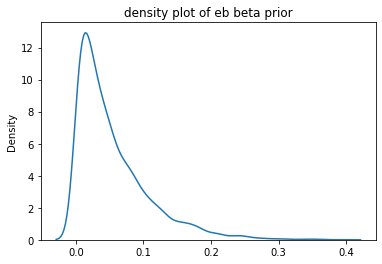

In [8]:
sns.kdeplot(r).set_title('density plot of eb beta prior')

In [9]:
video_df

video_id
103      0.025532
109      0.053154
120      0.102055
122      0.031228
128      0.023388
           ...   
10506    0.080351
10519    0.177098
10552    0.006383
10589    0.059914
10595    0.107988
Name: liked, Length: 3327, dtype: float64

## Step 2: Merge the datasets and select from test set different products

In [10]:
kuairec_test = pd.merge(kuairec_df, test_videos, on='video_id')
kuairec_test = kuairec_test.rename(columns={'liked_x': 'liked', 'liked_y': 'like_ratio'})

In [11]:
kuairec_test.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,liked,like_ratio
0,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377,0,0.145996
1,19,183,8033,6100,2020-07-25 09:51:33.664,20200725.0,1.595642e+09,1.316885,0,0.145996
2,21,183,15770,6100,2020-07-08 07:00:20.865,20200708.0,1.594163e+09,2.585246,1,0.145996
3,23,183,20786,6100,2020-07-05 07:50:01.81,20200705.0,1.593907e+09,3.407541,1,0.145996
4,24,183,4737,6100,2020-07-05 03:47:59.561,20200705.0,1.593892e+09,0.776557,0,0.145996


Text(0.5, 1.0, 'histogram of like ratios')

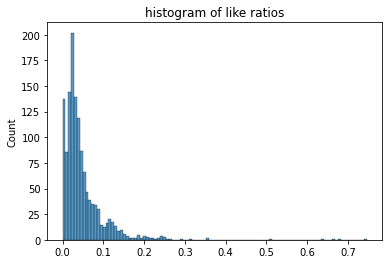

In [12]:
sns.histplot(test_videos.values).set_title('histogram of like ratios')

In [13]:
num_samples = 600

In [14]:
sampled_videos = (list(test_videos.sample(num_samples, random_state=1729).keys()))

In [15]:
kuairec_chosen = kuairec_test[kuairec_test['video_id'].isin(sampled_videos)]

In [16]:
video_df[sampled_videos].sort_values()

video_id
2007    0.000000
1197    0.000000
5998    0.000000
9136    0.000000
883     0.000000
          ...   
6879    0.248227
7559    0.253012
3723    0.311127
5464    0.662411
1305    0.676596
Name: liked, Length: 600, dtype: float64

In [17]:
videos_of_interest = video_df[sampled_videos].sort_values()
videos_of_interest = list(videos_of_interest.iloc[[-1, -2, num_samples//5, 2*num_samples//5, 3*num_samples//5, 4*num_samples//5]].keys())
videos_of_interest

[1305, 5464, 4226, 1997, 586, 6283]

In [18]:
indices_of_interest = [sampled_videos.index(item) for item in videos_of_interest]

## Step 3: Set up the bandit environment

In [19]:
# set up experiment in a way where we can later interpolate between uninformed prior and eb
uninformed_priors = np.ones(len(sampled_videos)*2).reshape(len(sampled_videos),2)
eb_priors = np.array([[prior_a]*len(sampled_videos),[prior_b]*len(sampled_videos)]).T

In [20]:
def random_argmax(alist):
  maxval = max(alist)
  argmax = [idx for idx, val in enumerate(alist) if val == maxval]
  return np.random.choice(argmax)

def ts_action(actions, num_success, num_failure):
  p_hat = [np.random.beta(num_success[a],num_failure[a]) for a in actions]
  a = random_argmax(p_hat)
  return a

def greedy_action(actions, num_success, num_failure):
  p_hat = [(num_success[a] + 1) / (num_success[a] + num_failure[a] + 2) for a in actions]
  a = random_argmax(p_hat)
  return a

def epsilon_greedy_action(actions, num_success, num_failure):
  if np.random.binomial(1, 0.05):
    a = np.random.choice(actions)
  else:
    a = greedy_action(actions, num_success, num_failure)
  return a

def sample_chosen_df(videos, chosen_df, action_index):
    vid = videos[action_index]
    seen_like = chosen_df[chosen_df['video_id']==vid].sample(1).iloc[0]['liked']
    return seen_like

#### Default multi-armed bandit algorithm

In [21]:
def run_multiarmed_bandit(chosen_df, 
                          videos, 
                          priors, 
                          sampling_action, 
                          timesteps, 
                          num_sims):

    agg_priors_over_time = []
    rewards_over_time = []
    plays = []
    
    for n in range(num_sims):
        instance_priors_over_time = [priors]
        instance_rewards_over_time = [np.zeros(len(videos))]
        instance_plays = np.zeros(len(videos))
        
        for t in range(timesteps):
            newest_prior = instance_priors_over_time[-1].copy()
            newest_rewards = instance_rewards_over_time[-1].copy()
            successes, failures = newest_prior.T[0,:], newest_prior.T[1,:]
            actions = range(len(videos))
            
            a = sampling_action(actions, successes, failures)
            
            instance_plays[a] += 1
            
            like = sample_chosen_df(videos, chosen_df, a)
            
            # update prior
            newest_prior[a,0] += like
            newest_prior[a,1] += 1 - like
            instance_priors_over_time.append(newest_prior)
            
            newest_rewards[a] += like
            instance_rewards_over_time.append(newest_rewards)
            
        instance_priors_over_time = np.stack(instance_priors_over_time)
        instance_rewards_over_time = np.stack(instance_rewards_over_time)
        
        agg_priors_over_time.append(instance_priors_over_time)
        rewards_over_time.append(instance_rewards_over_time)
        plays.append(instance_plays)
        
    agg_priors_over_time = np.stack(agg_priors_over_time)
    rewards_over_time = np.stack(rewards_over_time)
    plays = np.stack(plays)
            
    return agg_priors_over_time, rewards_over_time, plays
            
        

#### Multi-armed bandit where multiple users sample at each timestep

In [57]:
def run_multiarmed_bandit_many_users(chosen_df, 
                                     videos, 
                                     priors, 
                                     sampling_action, 
                                     timesteps, 
                                     num_sims,
                                     num_users=1):

    agg_priors_over_time = []
    rewards_over_time = []
    plays = []
    
    for n in range(num_sims):
        if (n+1) % 10 == 0:
            print(f'timestep {n+1}/{num_sims}')
            
        instance_priors_over_time = [priors]
        instance_rewards_over_time = [np.zeros(len(videos))]
        instance_plays = np.zeros(len(videos))
        
        for t in range(timesteps):
            newest_prior = instance_priors_over_time[-1].copy()
            newest_rewards = instance_rewards_over_time[-1].copy()
            successes, failures = newest_prior.T[0,:], newest_prior.T[1,:]
            actions = range(len(videos))

            for m in range(num_users):
                a = sampling_action(actions, successes, failures)

                instance_plays[a] += 1

                like = sample_chosen_df(videos, chosen_df, a)

                # update prior
                newest_prior[a,0] += like
                newest_prior[a,1] += 1 - like
                newest_rewards[a] += like
            instance_priors_over_time.append(newest_prior)
            instance_rewards_over_time.append(newest_rewards)
            
        instance_priors_over_time = np.stack(instance_priors_over_time)
        instance_rewards_over_time = np.stack(instance_rewards_over_time)
        
        agg_priors_over_time.append(instance_priors_over_time)
        rewards_over_time.append(instance_rewards_over_time)
        plays.append(instance_plays)
        
    agg_priors_over_time = np.stack(agg_priors_over_time)
    rewards_over_time = np.stack(rewards_over_time)
    plays = np.stack(plays)
            
    return agg_priors_over_time, rewards_over_time, plays
            
        

#### Multi-armed bandit with cycling products

In [104]:
def run_multiarmed_bandit_cycling_goods(chosen_df,
                                        videos,
                                        priors,
                                        sampling_action,
                                        timesteps,
                                        rho,
                                        num_sims,
                                        num_starting,
                                        num_users=1):
    agg_priors_over_time = []
    rewards_over_time = []
    plays = []
    
    for n in range(num_sims):
        if (n+1) % 10 == 0:
            print(f'timestep {n+1}/{num_sims}')
            
        curr_vids = list(np.random.choice(videos, num_starting))
        curr_vids_indices = [videos.index(v) for v in curr_vids]
        remaining_vids = list(set(videos).difference(set(curr_vids)))
        random.shuffle(remaining_vids)
        curr_chosen_df = chosen_df[chosen_df['video_id'].isin(curr_vids)]
            
        instance_priors_over_time = [priors]
        instance_rewards_over_time = [np.zeros(len(videos))]
        instance_plays = np.zeros(len(videos))
        
        for t in range(timesteps):
            cycle = np.random.binomial(1, rho)
            if cycle > 0 and len(remaining_vids) > 0:
                curr_vids = curr_vids[1:]
                curr_vids.append(remaining_vids.pop())
                curr_vids_indices = [videos.index(v) for v in curr_vids]
                curr_chosen_df = chosen_df[chosen_df['video_id'].isin(curr_vids)]
            
            newest_prior = instance_priors_over_time[-1].copy()
            newest_rewards = instance_rewards_over_time[-1].copy()
            successes, failures = newest_prior.T[0, curr_vids_indices], newest_prior.T[1, curr_vids_indices]
            actions = range(len(curr_vids))
            for m in range(num_users):
                a = curr_vids_indices[sampling_action(actions, successes, failures)]

                instance_plays[a] += 1

                like = sample_chosen_df(videos, chosen_df, a)

                # update prior
                newest_prior[a,0] += like
                newest_prior[a,1] += 1 - like
                newest_rewards[a] += like
            instance_priors_over_time.append(newest_prior)
            instance_rewards_over_time.append(newest_rewards)
            
        instance_priors_over_time = np.stack(instance_priors_over_time)
        instance_rewards_over_time = np.stack(instance_rewards_over_time)
        
        agg_priors_over_time.append(instance_priors_over_time)
        rewards_over_time.append(instance_rewards_over_time)
        plays.append(instance_plays)
        
    agg_priors_over_time = np.stack(agg_priors_over_time)
    rewards_over_time = np.stack(rewards_over_time)
    plays = np.stack(plays)
            
    return agg_priors_over_time, rewards_over_time, plays

## Step 4: Run the simulations and save data

In [60]:
timesteps = 100
num_sims = 100
num_users = 10

In [42]:
uninformed_prior_data, uninformed_rewards_data, uninformed_plays_data = run_multiarmed_bandit(kuairec_chosen,
                                                                       sampled_videos,
                                                                       uninformed_priors,
                                                                       ts_action,
                                                                       timesteps=timesteps,
                                                                       num_sims=num_sims)

In [43]:
eb_prior_data, eb_rewards_data, eb_plays_data = run_multiarmed_bandit(kuairec_chosen,
                                                       sampled_videos,
                                                       eb_priors,
                                                       ts_action,
                                                       timesteps=timesteps,
                                                       num_sims=num_sims)

In [44]:
# uninformed_greedy_prior_data, uninformed_greedy_rewards_data, uninformed_greedy_plays_data = run_multiarmed_bandit(kuairec_chosen,
#                                                                        sampled_videos,
#                                                                        uninformed_priors,
#                                                                        epsilon_greedy_action,
#                                                                        timesteps=timesteps,
#                                                                        num_sims=num_sims)

In [45]:
# eb_greedy_prior_data, eb_greedy_rewards_data, eb_greedy_plays_data = run_multiarmed_bandit(kuairec_chosen,
#                                                                        sampled_videos,
#                                                                        eb_priors,
#                                                                        epsilon_greedy_action,
#                                                                        timesteps=timesteps,
#                                                                        num_sims=num_sims)

In [106]:
uninformed_multiuser_prior_data, uninformed_multiuser_rewards_data, uninformed_multiuser_plays_data = run_multiarmed_bandit_many_users(kuairec_chosen,
                                                                                                                                       sampled_videos,
                                                                                                                                       uninformed_priors,
                                                                                                                                       ts_action,
                                                                                                                                       timesteps=timesteps,
                                                                                                                                       num_sims=num_sims,
                                                                                                                                       num_users = num_users)


timestep 10/100
timestep 20/100
timestep 30/100
timestep 40/100
timestep 50/100
timestep 60/100
timestep 70/100
timestep 80/100
timestep 90/100
timestep 100/100


In [107]:
eb_multiuser_prior_data, eb_multiuser_rewards_data, eb_multiuser_plays_data = run_multiarmed_bandit_many_users(kuairec_chosen,
                                                                                                               sampled_videos,
                                                                                                               eb_priors,
                                                                                                               ts_action,
                                                                                                               timesteps=timesteps,
                                                                                                               num_sims=num_sims,
                                                                                                               num_users = num_users)


timestep 10/100
timestep 20/100
timestep 30/100
timestep 40/100
timestep 50/100
timestep 60/100
timestep 70/100
timestep 80/100
timestep 90/100
timestep 100/100


In [105]:
uninformed_cycling_prior_data, uninformed_cycling_rewards_data, uninformed_cycling_plays_data = run_multiarmed_bandit_cycling_goods(kuairec_chosen,
                                                                                                                                    sampled_videos,
                                                                                                                                    uninformed_priors,
                                                                                                                                    ts_action,
                                                                                                                                    timesteps=timesteps,
                                                                                                                                    rho=0.05,
                                                                                                                                    num_sims=num_sims,
                                                                                                                                    num_starting=10)

timestep 10/100
timestep 20/100
timestep 30/100
timestep 40/100
timestep 50/100
timestep 60/100
timestep 70/100
timestep 80/100
timestep 90/100
timestep 100/100


In [108]:
eb_cycling_prior_data, eb_cycling_rewards_data, eb_cycling_plays_data = run_multiarmed_bandit_cycling_goods(kuairec_chosen,
                                                                                                            sampled_videos,
                                                                                                            eb_priors,
                                                                                                            ts_action,
                                                                                                            timesteps=timesteps,
                                                                                                            rho=0.05,
                                                                                                            num_sims=num_sims,
                                                                                                            num_starting=10)

timestep 10/100
timestep 20/100
timestep 30/100
timestep 40/100
timestep 50/100
timestep 60/100
timestep 70/100
timestep 80/100
timestep 90/100
timestep 100/100


## Step 5: Plot and analyze the data

In [65]:
print(uninformed_prior_data.shape)
print(uninformed_rewards_data.shape)
print(uninformed_plays_data.shape)

(100, 101, 600, 2)
(100, 101, 600)
(100, 600)


In [66]:
def mean_data_to_df(data, videos_of_interest):
    li = []
    for i in range(data.shape[0]):
        df = pd.DataFrame(data[i,:,:])
        df = df.rename(columns=dict(zip(range(len(videos_of_interest)), videos_of_interest)))
        df = df.melt()
        df['timestep'] = list(range(data.shape[1]))*data.shape[2]
        df['sim #'] = i+1
        li.append(df)

    return pd.concat(li, ignore_index=True)

In [109]:
uninformed_means_data = (uninformed_prior_data[:,:,indices_of_interest,0]/(uninformed_prior_data[:,:,indices_of_interest,0]+uninformed_prior_data[:,:,indices_of_interest,1]))
eb_means_data = (eb_prior_data[:,:,indices_of_interest,0]/(eb_prior_data[:,:,indices_of_interest,0] + eb_prior_data[:,:,indices_of_interest,1]))
# uninformed_greedy_means_data = (uninformed_greedy_prior_data[:,:,indices_of_interest,0]/(uninformed_greedy_prior_data[:,:,indices_of_interest,0] + uninformed_greedy_prior_data[:,:,indices_of_interest,1]))
# eb_greedy_means_data = (eb_greedy_prior_data[:,:,indices_of_interest,0]/(eb_greedy_prior_data[:,:,indices_of_interest,0] + eb_greedy_prior_data[:,:,indices_of_interest,1]))
uninformed_multiuser_data = (uninformed_multiuser_prior_data[:,:,indices_of_interest,0]/(uninformed_multiuser_prior_data[:,:,indices_of_interest,0] + uninformed_multiuser_prior_data[:,:,indices_of_interest,1]))
eb_multiuser_data = (eb_multiuser_prior_data[:,:,indices_of_interest,0]/(eb_multiuser_prior_data[:,:,indices_of_interest,0] + eb_multiuser_prior_data[:,:,indices_of_interest,1]))
uninformed_cycling_data = (uninformed_cycling_prior_data[:,:,indices_of_interest,0]/(uninformed_cycling_prior_data[:,:,indices_of_interest,0] + uninformed_cycling_prior_data[:,:,indices_of_interest,1]))
eb_cycling_data = (eb_cycling_prior_data[:,:,indices_of_interest,0]/(eb_cycling_prior_data[:,:,indices_of_interest,0]+eb_cycling_prior_data[:,:,indices_of_interest,1]))


uninformed_rewards = uninformed_rewards_data[:,:,indices_of_interest].mean(axis=0)
eb_rewards = eb_rewards_data[:,:,indices_of_interest].mean(axis=0)
# uninformed_greedy_rewards = uninformed_greedy_rewards_data[:,:,indices_of_interest].mean(axis=0)
# eb_greedy_rewards = eb_greedy_rewards_data[:,:,indices_of_interest].mean(axis=0)
uninformed_multiuser_rewards = uninformed_multiuser_rewards_data[:,:,indices_of_interest].mean(axis=0)
eb_multiuser_rewards = eb_multiuser_rewards_data[:,:,indices_of_interest].mean(axis=0)
uninformed_cycling_rewards = uninformed_cycling_rewards_data[:,:,indices_of_interest].mean(axis=0)
eb_cycling_rewards = eb_cycling_rewards_data[:,:,indices_of_interest].mean(axis=0)

uninformed_plays = uninformed_plays_data[:,indices_of_interest].mean(axis=0)
eb_plays = eb_plays_data[:,indices_of_interest].mean(axis=0)
# uninformed_greedy_plays = uninformed_greedy_plays_data[:,indices_of_interest].mean(axis=0)
# eb_greedy_plays = eb_greedy_plays_data[:,indices_of_interest].mean(axis=0)
uninformed_multiuser_plays = uninformed_multiuser_plays_data[:,indices_of_interest].mean(axis=0)
eb_multiuser_plays = eb_multiuser_plays_data[:,indices_of_interest].mean(axis=0)
uninformed_cycling_plays = uninformed_cycling_plays_data[:,indices_of_interest].mean(axis=0)
eb_cycling_plays = eb_cycling_plays_data[:,indices_of_interest].mean(axis=0)

In [112]:
# calculate means

uninformed_means = uninformed_means_data.mean(axis=0)
eb_means = eb_means_data.mean(axis=0)
# uninformed_greedy_means = uninformed_greedy_means_data.mean(axis=0)
# eb_greedy_means = eb_greedy_means_data.mean(axis=0)
uninformed_mu_means = uninformed_multiuser_data.mean(axis=0)
eb_mu_means = eb_multiuser_data.mean(axis=0)
uninformed_cycling_means = uninformed_cycling_data.mean(axis=0)
eb_cycling_means = eb_cycling_data.mean(axis=0)

In [113]:
# calculate confidence intervals
uninf_conf_width = beta.interval(0.95, uninformed_prior_data[:,:,indices_of_interest,0], uninformed_prior_data[:,:,indices_of_interest,1])
uninf_conf_width = uninf_conf_width[1] - uninf_conf_width[0]
uninf_conf_width = uninf_conf_width.mean(axis=0)

eb_conf_width = beta.interval(0.95, eb_prior_data[:,:,indices_of_interest,0], eb_prior_data[:,:,indices_of_interest,1])
eb_conf_width = eb_conf_width[1] - eb_conf_width[0]
eb_conf_width = eb_conf_width.mean(axis=0)

# uninf_greedy_conf_width = beta.interval(0.95, uninformed_greedy_prior_data[:,:,indices_of_interest,0], uninformed_greedy_prior_data[:,:,indices_of_interest,1])
# uninf_greedy_conf_width = uninf_greedy_conf_width[1] - uninf_greedy_conf_width[0]
# uninf_greedy_conf_width = uninf_greedy_conf_width.mean(axis=0)

# eb_greedy_conf_width = beta.interval(0.95, eb_greedy_prior_data[:,:,indices_of_interest,0], eb_greedy_prior_data[:,:,indices_of_interest,1])
# eb_greedy_conf_width = eb_greedy_conf_width[1] - eb_greedy_conf_width[0]
# eb_greedy_conf_width = eb_greedy_conf_width.mean(axis=0)

uninf_mu_conf_width = beta.interval(0.95, uninformed_multiuser_prior_data[:,:,indices_of_interest,0], uninformed_multiuser_prior_data[:,:,indices_of_interest,1])
uninf_mu_conf_width = uninf_mu_conf_width[1] - uninf_mu_conf_width[0]
uninf_mu_conf_width = uninf_mu_conf_width.mean(axis=0)

eb_mu_conf_width = beta.interval(0.95, eb_multiuser_prior_data[:,:,indices_of_interest,0], eb_multiuser_prior_data[:,:,indices_of_interest,1])
eb_mu_conf_width = eb_mu_conf_width[1] - eb_mu_conf_width[0]
eb_mu_conf_width = eb_mu_conf_width.mean(axis=0)

uninf_cycling_conf_width = beta.interval(0.95, uninformed_cycling_prior_data[:,:,indices_of_interest,0], uninformed_cycling_prior_data[:,:,indices_of_interest,1])
uninf_cycling_conf_width = uninf_cycling_conf_width[1] - uninf_cycling_conf_width[0]
uninf_cycling_conf_width = uninf_cycling_conf_width.mean(axis=0)

eb_cycling_conf_width = beta.interval(0.95, eb_cycling_prior_data[:,:,indices_of_interest,0], eb_cycling_prior_data[:,:,indices_of_interest,1])
eb_cycling_conf_width = eb_cycling_conf_width[1] - eb_cycling_conf_width[0]
eb_cycling_conf_width = eb_cycling_conf_width.mean(axis=0)

In [114]:
# calculate variance of quality

uninformed_vars = uninformed_means_data.var(axis=0)
eb_vars = eb_means_data.var(axis=0)
# uninformed_greedy_vars = uninformed_greedy_means_data.var(axis=0)
# eb_greedy_vars = eb_greedy_means_data.var(axis=0)
uninformed_mu_vars = uninformed_multiuser_data.var(axis=0)
eb_mu_vars = eb_multiuser_data.var(axis=0)
uninformed_cycling_vars = uninformed_cycling_data.var(axis=0)
eb_cycling_vars = eb_cycling_data.var(axis=0)

### 5.1: Plotting estimated quality, reward, confidence interval width, variance

true vals [0.6766, 0.6624, 0.0142, 0.0248, 0.0383, 0.0682]
estimated means [0.5085 0.5025 0.4817 0.4567 0.4692 0.4567]
arm pulls [0.22 0.12 0.11 0.26 0.21 0.3 ]


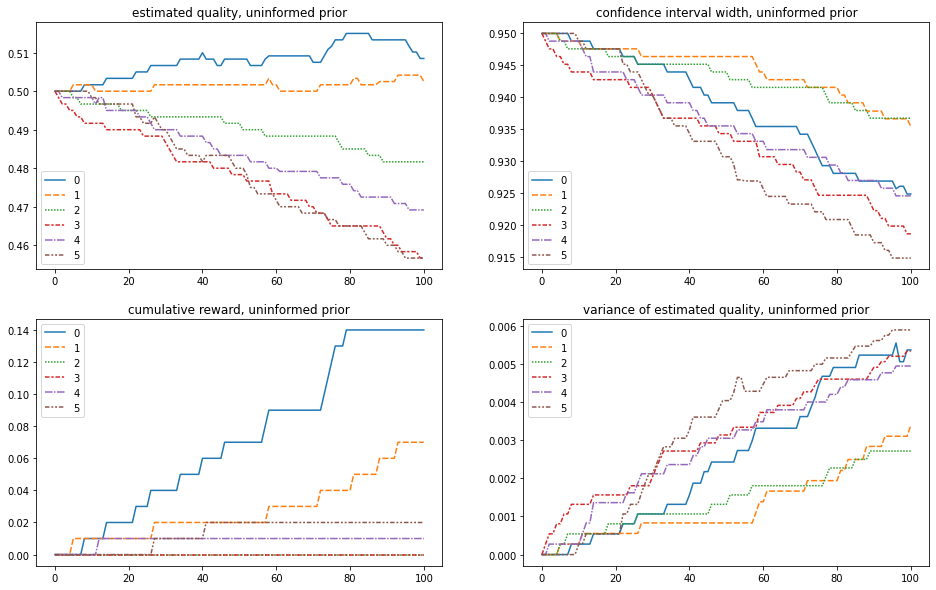

In [52]:
f, axes = plt.subplots(2,2)
f.set_size_inches(16,10)
sns.lineplot(uninformed_means, ax=axes[0,0]).set_title('estimated quality, uninformed prior')
sns.lineplot(uninformed_rewards, ax=axes[1,0]).set_title('cumulative reward, uninformed prior')
sns.lineplot(uninf_conf_width, ax=axes[0,1]).set_title('confidence interval width, uninformed prior')
sns.lineplot(uninformed_vars, ax=axes[1,1]).set_title('variance of estimated quality, uninformed prior')
print('true vals', list(video_df[videos_of_interest].values.round(4)))
print('estimated means', uninformed_means[-1,:].round(4))
print('arm pulls', uninformed_plays)

true vals [0.6766, 0.6624, 0.0142, 0.0248, 0.0383, 0.0682]
estimated means [0.0605 0.0605 0.0538 0.0539 0.0544 0.0538]
arm pulls [0.32 0.18 0.17 0.13 0.14 0.18]


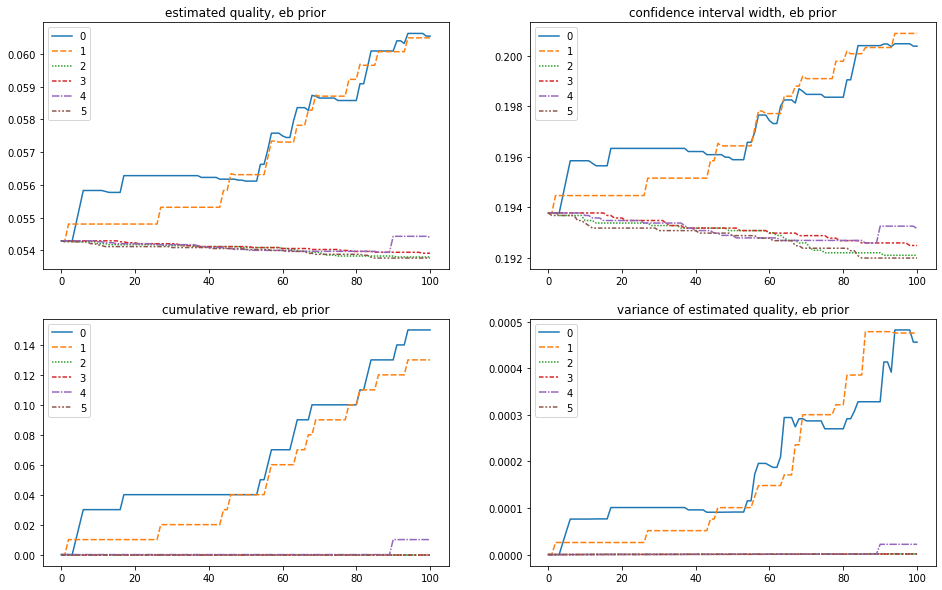

In [53]:
f, axes = plt.subplots(2,2)
f.set_size_inches(16, 10)
sns.lineplot(eb_means, ax=axes[0,0]).set_title('estimated quality, eb prior')
sns.lineplot(eb_rewards, ax=axes[1,0]).set_title('cumulative reward, eb prior')
sns.lineplot(eb_conf_width, ax=axes[0,1]).set_title('confidence interval width, eb prior')
sns.lineplot(eb_vars, ax=axes[1,1]).set_title('variance of estimated quality, eb prior')
print('true vals', list(video_df[videos_of_interest].values.round(4)))
print('estimated means', eb_means[-1,:].round(4))
print('arm pulls', eb_plays)

### 5.2 Demonstrating that with current parameter settings we have far too much noise

Text(0.5, 1.0, 'quality of items, uninformed prior')

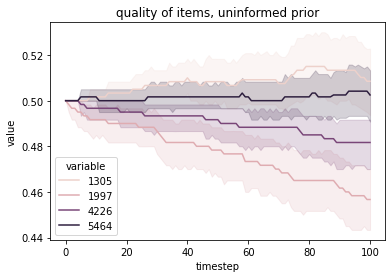

In [89]:
sns.lineplot(data=mean_data_to_df(uninformed_means_data[:,:,:4], videos_of_interest[:4]),
             x='timestep',
             y='value',
             hue='variable').set_title('quality of items, uninformed prior')

Text(0.5, 1.0, 'quality of items, eb prior')

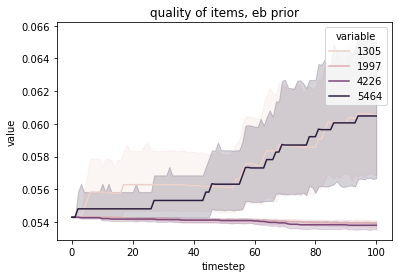

In [90]:
sns.lineplot(data=mean_data_to_df(eb_means_data[:,:,:4], videos_of_interest[:4]),
             x='timestep',
             y='value',
             hue='variable').set_title('quality of items, eb prior')

In [37]:
# f, axes = plt.subplots(2,2)
# f.set_size_inches(16, 10)
# sns.lineplot(uninformed_greedy_means, ax=axes[0,0]).set_title('estimated quality, uninformed+greedy')
# sns.lineplot(uninformed_greedy_rewards, ax=axes[1,0]).set_title('cumulative reward, uninformed+greedy')
# sns.lineplot(uninf_greedy_conf_width, ax=axes[0,1]).set_title('confidence interval width, uninformed+greedy')
# sns.lineplot(uninformed_greedy_vars, ax=axes[1,1]).set_title('variance of estimated quality, uninformed+greedy')
# print('true vals', list(video_df[videos_of_interest].values.round(4)))
# print('estimated means', uninformed_greedy_means[-1,:].round(4))
# print('arm pulls', uninformed_greedy_plays)

In [38]:
# f, axes = plt.subplots(1, 3)
# f.set_size_inches(16, 5)
# sns.lineplot(eb_greedy_means, ax=axes[0]).set_title('estimated quality, eb+greedy')
# sns.lineplot(eb_greedy_rewards, ax=axes[1]).set_title('cumulative reward, eb+greedy')
# sns.lineplot(eb_greedy_conf_width, ax=axes[2]).set_title('confidence interval width, eb+greedy')
# print('true vals', list(video_df[videos_of_interest].values.round(4)))
# print('estimated means', eb_greedy_means[-1,:].round(4))
# print('arm pulls', eb_greedy_plays)

### 5.3 Showing results on multi-user data

true vals [0.6766, 0.6624, 0.0142, 0.0248, 0.0383, 0.0682]
estimated means [0.5578 0.5305 0.2923 0.2913 0.2963 0.3063]
arm pulls [6.41 5.92 1.58 1.6  1.53 1.77]


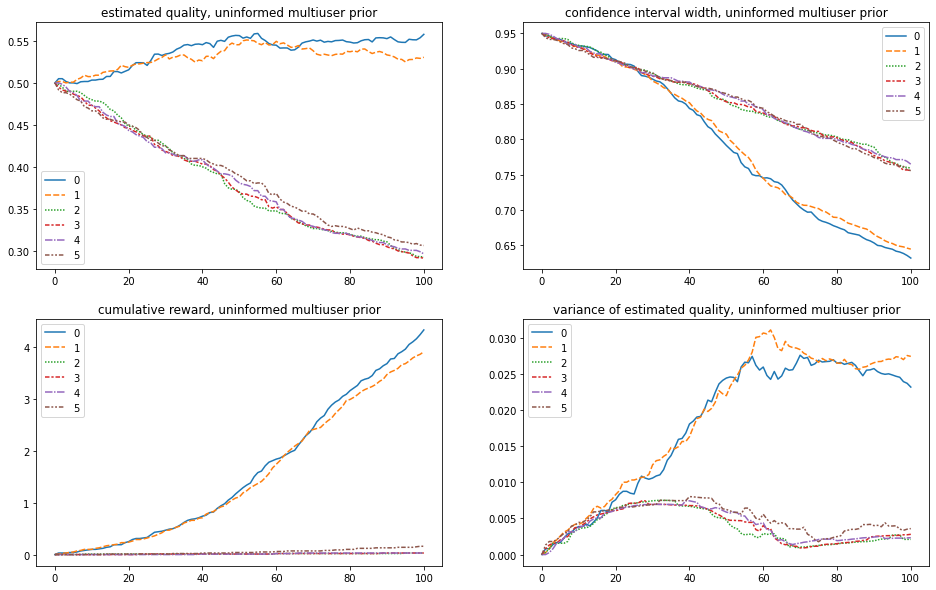

In [75]:
f, axes = plt.subplots(2,2)
f.set_size_inches(16,10)
sns.lineplot(uninformed_mu_means, ax=axes[0,0]).set_title('estimated quality, uninformed multiuser prior')
sns.lineplot(uninformed_multiuser_rewards, ax=axes[1,0]).set_title('cumulative reward, uninformed multiuser prior')
sns.lineplot(uninf_mu_conf_width, ax=axes[0,1]).set_title('confidence interval width, uninformed multiuser prior')
sns.lineplot(uninformed_mu_vars, ax=axes[1,1]).set_title('variance of estimated quality, uninformed multiuser prior')
print('true vals', list(video_df[videos_of_interest].values.round(4)))
print('estimated means', uninformed_mu_means[-1,:].round(4))
print('arm pulls', uninformed_multiuser_plays)

true vals [0.6766, 0.6624, 0.0142, 0.0248, 0.0383, 0.0682]
estimated means [0.2837 0.302  0.0525 0.0534 0.053  0.0527]
arm pulls [186.48 205.71   0.98   1.02   0.97   0.95]


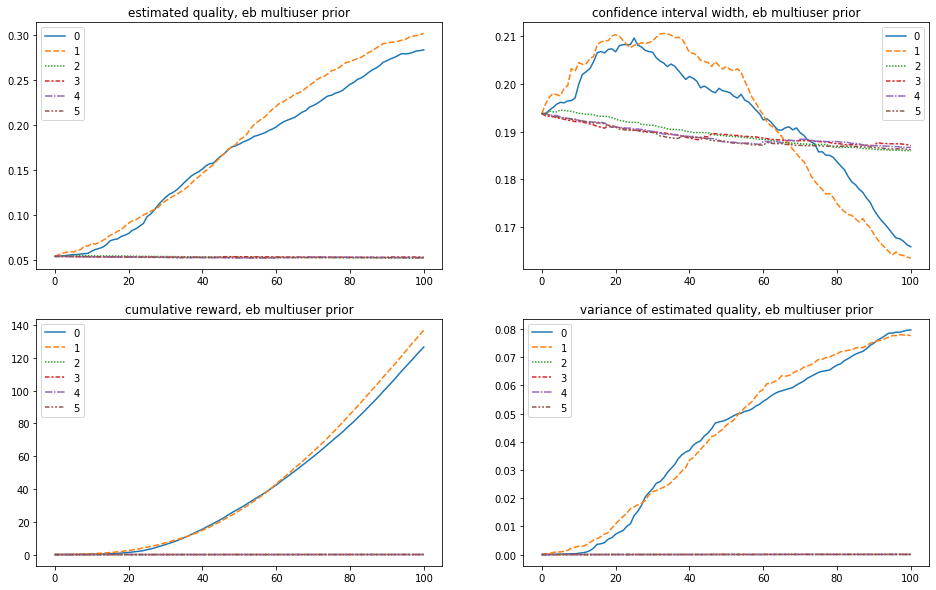

In [76]:
f, axes = plt.subplots(2,2)
f.set_size_inches(16,10)
sns.lineplot(eb_mu_means, ax=axes[0,0]).set_title('estimated quality, eb multiuser prior')
sns.lineplot(eb_multiuser_rewards, ax=axes[1,0]).set_title('cumulative reward, eb multiuser prior')
sns.lineplot(eb_mu_conf_width, ax=axes[0,1]).set_title('confidence interval width, eb multiuser prior')
sns.lineplot(eb_mu_vars, ax=axes[1,1]).set_title('variance of estimated quality, eb multiuser prior')
print('true vals', list(video_df[videos_of_interest].values.round(4)))
print('estimated means', eb_mu_means[-1,:].round(4))
print('arm pulls', eb_multiuser_plays)

Text(0.5, 1.0, 'quality of items, uninformed multiuser prior')

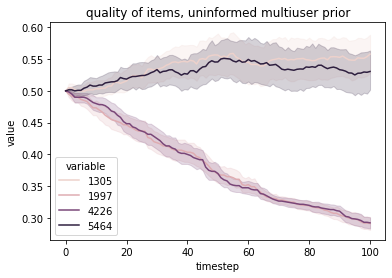

In [91]:
sns.lineplot(data=mean_data_to_df(uninformed_multiuser_data[:,:,:4], videos_of_interest[:4]),
             x='timestep',
             y='value',
             hue='variable').set_title('quality of items, uninformed multiuser prior')

Text(0.5, 1.0, 'quality of items, eb multiuser prior')

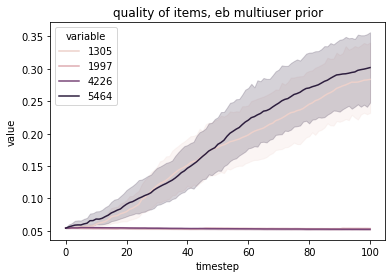

In [92]:
sns.lineplot(data=mean_data_to_df(eb_multiuser_data[:,:,:4], videos_of_interest[:4]),
             x='timestep',
             y='value',
             hue='variable').set_title('quality of items, eb multiuser prior')

### 5.4 Showing results on cycling data

true vals [0.6766, 0.6624, 0.0142, 0.0248, 0.0383, 0.0682]
estimated means [0.5021 0.5017 0.4967 0.4957 0.486  0.4927]
arm pulls [0.46 0.46 0.04 0.07 0.22 0.11]


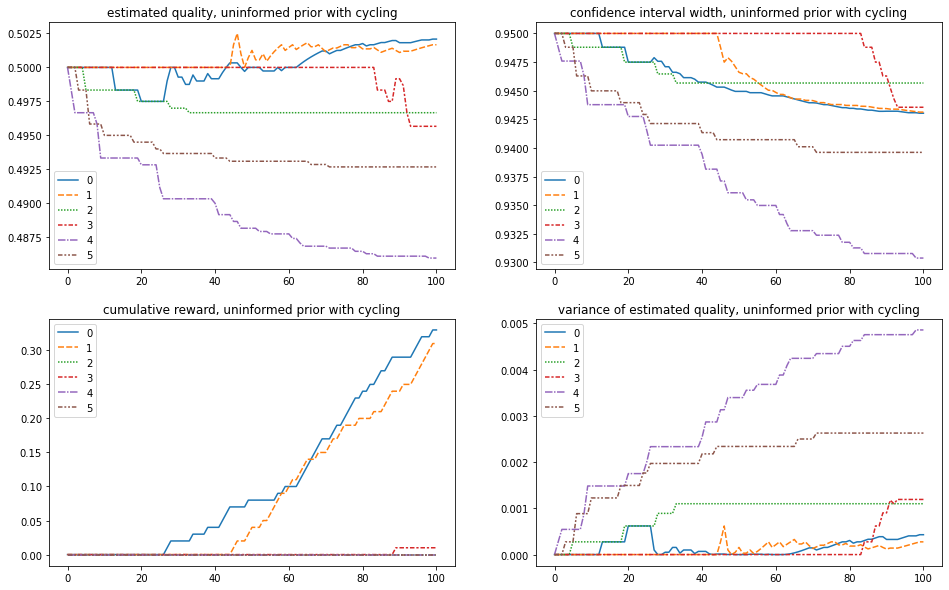

In [115]:
f, axes = plt.subplots(2,2)
f.set_size_inches(16,10)
sns.lineplot(uninformed_cycling_means, ax=axes[0,0]).set_title('estimated quality, uninformed prior with cycling')
sns.lineplot(uninformed_cycling_rewards, ax=axes[1,0]).set_title('cumulative reward, uninformed prior with cycling')
sns.lineplot(uninf_cycling_conf_width, ax=axes[0,1]).set_title('confidence interval width, uninformed prior with cycling')
sns.lineplot(uninformed_cycling_vars, ax=axes[1,1]).set_title('variance of estimated quality, uninformed prior with cycling')
print('true vals', list(video_df[videos_of_interest].values.round(4)))
print('estimated means', uninformed_cycling_means[-1,:].round(4))
print('arm pulls', uninformed_cycling_plays)

true vals [0.6766, 0.6624, 0.0142, 0.0248, 0.0383, 0.0682]
estimated means [0.0543 0.0592 0.0541 0.0543 0.0543 0.0542]
arm pulls [0.01 0.7  0.1  0.   0.   0.21]


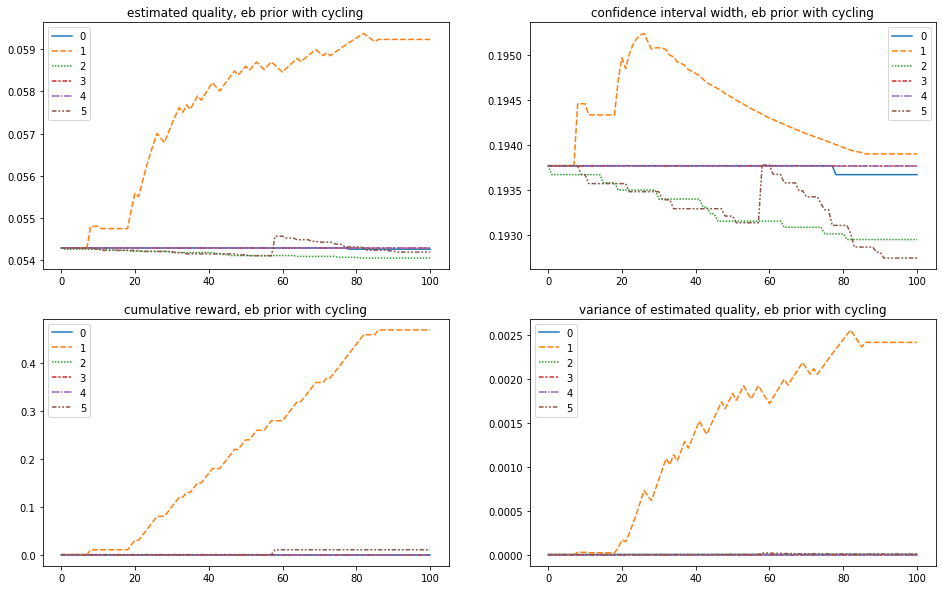

In [116]:
f, axes = plt.subplots(2,2)
f.set_size_inches(16,10)
sns.lineplot(eb_cycling_means, ax=axes[0,0]).set_title('estimated quality, eb prior with cycling')
sns.lineplot(eb_cycling_rewards, ax=axes[1,0]).set_title('cumulative reward, eb prior with cycling')
sns.lineplot(eb_cycling_conf_width, ax=axes[0,1]).set_title('confidence interval width, eb prior with cycling')
sns.lineplot(eb_cycling_vars, ax=axes[1,1]).set_title('variance of estimated quality, eb prior with cycling')
print('true vals', list(video_df[videos_of_interest].values.round(4)))
print('estimated means', eb_cycling_means[-1,:].round(4))
print('arm pulls', eb_cycling_plays)

Text(0.5, 1.0, 'quality of items, uninformed prior with cycling')

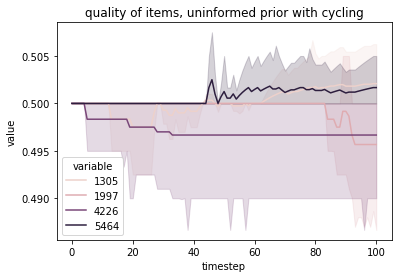

In [117]:
sns.lineplot(data=mean_data_to_df(uninformed_cycling_data[:,:,:4], videos_of_interest[:4]),
             x='timestep',
             y='value',
             hue='variable').set_title('quality of items, uninformed prior with cycling')

Text(0.5, 1.0, 'quality of items, eb prior with cycling')

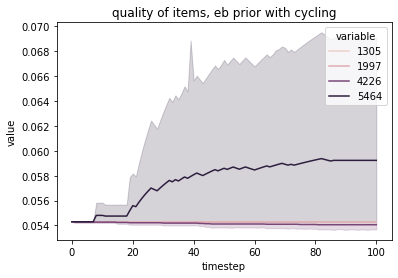

In [119]:
sns.lineplot(data=mean_data_to_df(eb_cycling_data[:,:,:4], videos_of_interest[:4]),
             x='timestep',
             y='value',
             hue='variable').set_title('quality of items, eb prior with cycling')